<a href="https://colab.research.google.com/github/jimmy-pink/colab-playground/blob/main/pre-trained/ResNet50V2-FolderIconRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 使用ResNet50V2微调以解决FolderIcon二分类问题

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.optimizers import Adam

### 数据准备

In [3]:
## 转存 https://drive.google.com/drive/folders/1xwtf91GSyeIc7ohpCKsDCYv3zXgKa0sf
from google.colab import drive
drive.mount('/content/drive')

# 挂载 Google Drive
base_dir = '/content/drive/MyDrive/Google AI Studio/data/folder-icon-images/'  # Google Drive 中的图像文件夹路径
train_dir=base_dir+'is_folder'
drive_train_validate_dir = base_dir + "train_validate"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 设置数据增强
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True)

# 使用 flow_from_directory 加载训练数据
# 数据增强 + 归一化
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    validation_split=0.3  # 30% 作为验证集
)

# 训练集生成器
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',  # 二分类用 binary，多分类用 categorical
    subset='training'  # 指定是训练集
)

# 验证集生成器
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # 指定是验证集
)
print(f"找到的训练样本数: {train_generator.samples}")
print(f"找到的验证样本数: {validation_generator.samples}")
images, labels = next(train_generator)
print("图像形状:", images.shape)
print("标签形状:", labels.shape)

Found 1734 images belonging to 2 classes.
Found 742 images belonging to 2 classes.
找到的训练样本数: 1734
找到的验证样本数: 742


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


图像形状: (32, 224, 224, 3)
标签形状: (32,)


In [5]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
# 获取训练集的真实标签（需确保 train_generator.classes 是整数标签 0/1）
y_train = train_generator.classes
# 计算类别权重（classes 需是 NumPy 数组）
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),  # 自动提取唯一类别（如 [0, 1]）
    y=y_train
)
# 转换为字典格式
class_weights = {i: weight for i, weight in enumerate(class_weights)}
print("类别权重:", class_weights)

类别权重: {0: np.float64(0.8442064264849075), 1: np.float64(1.2263083451202264)}


### 建模

In [11]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras import layers, models

base_model = ResNet50V2(
    weights='imagenet',  # 使用预训练权重
    include_top=False,   # 不包含顶层分类器
    input_shape=(224, 224, 3)
)


# 冻结前 n% 的层
freeze_until = int(len(base_model.layers) * 0.9)
for i, layer in enumerate(base_model.layers):
    layer.trainable = i >= freeze_until

In [12]:
import os
save_dir = '/content/drive/MyDrive/Google AI Studio/saved_models'
# 如果目录不存在，则创建
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
model_file_save_path = f'{save_dir}/ResNet50V2_folder_icon_shape_predict_model.h5'

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras import regularizers

model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.7),
    layers.Dense(126, activation='relu', kernel_regularizer=regularizers.l2(0.04)),
    layers.Dropout(0.6),
    layers.Dense(1, activation='sigmoid')  # 二分类输出
])

optimizer = AdamW(learning_rate=5e-5, weight_decay=1e-4)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [19]:
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') >= 0.98 and logs.get('val_loss') < 0.2 ):
            self.model.stop_training = True

callbacks = [
    ModelCheckpoint(
        model_file_save_path,
        monitor='val_accuracy',  # 监控验证准确率
        save_best_only=True,     # 只保留最佳
        mode='max'               # 取最大值
    ),
    EarlyStopping(monitor='val_loss', patience=5),
    myCallback()
]

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    class_weight=class_weights,
          verbose=1,
          callbacks=callbacks
)

Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.7254 - loss: 9.9440

55/55 ━━━━━━━━━━━━━━━━━━━━ 45s 511ms/step - accuracy: 0.7274 - loss: 9.9353 - val_accuracy: 0.9447 - val_loss: 8.8670
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.9342 - loss: 8.6400

55/55 ━━━━━━━━━━━━━━━━━━━━ 19s 340ms/step - accuracy: 0.9345 - loss: 8.6358 - val_accuracy: 0.9528 - val_loss: 8.0462
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 19s 338ms/step - accuracy: 0.9668 - loss: 7.7719 - val_accuracy: 0.9515 - val_loss: 7.2876
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 269ms/step - accuracy: 0.9762 - loss: 7.0057 - val_accuracy: 0.9528 - val_loss: 6.5667
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.9842 - loss: 6.2739

55/55 ━━━━━━━━━━━━━━━━━━━━ 17s 303ms/step - accuracy: 0.9842 - loss: 6.2712 - val_accuracy: 0.9542 - val_loss: 5.8949
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 18s 319ms/step - accuracy: 0.9866 - loss: 5.6345 - val_accuracy: 0.9542 - val_loss: 5.3050
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.9946 - loss: 5.0210

55/55 ━━━━━━━━━━━━━━━━━━━━ 17s 317ms/step - accuracy: 0.9946 - loss: 5.0185 - val_accuracy: 0.9555 - val_loss: 4.7641
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 23s 342ms/step - accuracy: 0.9964 - loss: 4.4749 - val_accuracy: 0.9515 - val_loss: 4.2600
Epoch 9/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 273ms/step - accuracy: 0.9874 - loss: 3.9973 - val_accuracy: 0.9515 - val_loss: 3.8060
Epoch 10/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 272ms/step - accuracy: 0.9924 - loss: 3.5408 - val_accuracy: 0.9542 - val_loss: 3.3911
Epoch 11/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 267ms/step - accuracy: 0.9948 - loss: 3.1373 - val_accuracy: 0.9528 - val_loss: 3.0628
Epoch 12/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 265ms/step - accuracy: 0.9950 - loss: 2.7756 - val_accuracy: 0.9555 - val_loss: 2.7073
Epoch 13/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.9979 - loss: 2.4513

55/55 ━━━━━━━━━━━━━━━━━━━━ 17s 301ms/step - accuracy: 0.9978 - loss: 2.4500 - val_accuracy: 0.9582 - val_loss: 2.4189
Epoch 14/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.9912 - loss: 2.1857

55/55 ━━━━━━━━━━━━━━━━━━━━ 26s 472ms/step - accuracy: 0.9912 - loss: 2.1844 - val_accuracy: 0.9609 - val_loss: 2.1496
Epoch 15/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 20s 347ms/step - accuracy: 0.9926 - loss: 1.9307 - val_accuracy: 0.9609 - val_loss: 1.9289
Epoch 16/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 277ms/step - accuracy: 0.9957 - loss: 1.6921 - val_accuracy: 0.9582 - val_loss: 1.7106
Epoch 17/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 270ms/step - accuracy: 0.9948 - loss: 1.4925 - val_accuracy: 0.9569 - val_loss: 1.5249
Epoch 18/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 277ms/step - accuracy: 0.9969 - loss: 1.3178 - val_accuracy: 0.9609 - val_loss: 1.3673
Epoch 19/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 282ms/step - accuracy: 0.9961 - loss: 1.1583 - val_accuracy: 0.9609 - val_loss: 1.2159
Epoch 20/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 282ms/step - accuracy: 0.9919 - loss: 1.0234 - val_accuracy: 0.9515 - val_loss: 1.0700


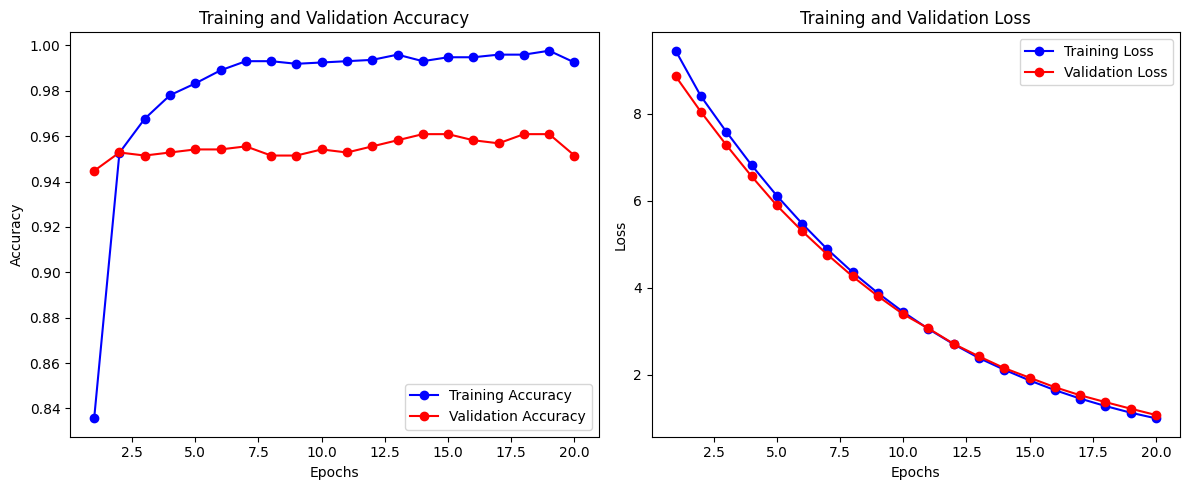

In [20]:
import matplotlib.pyplot as plt

# 提取历史数据
epochs = range(1, len(history.history['loss']) + 1)
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# 绘制 accuracy 和 val_accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 绘制 loss 和 val_loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()